## On essaye de calculer les forces de pression autour du cylindre 

In [11]:
from animate import anim 
import numpy as np
import torch 
from model import PINNs
from deepxrte.geometry import Rectangle
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt

In [12]:
# On importe le modèle entrainé

with open("results/1_first_try" + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)

model = PINNs(hyper_param)
checkpoint = torch.load('results/1_first_try/epoch3200'+'/model_weights.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [13]:
param_adim = {
    'V':2,
    'L':0.025,
    'rho': 1.2
}

In [14]:
X_train, U_train, X_full, U_full, X_border, mean_std = charge_data(hyper_param, param_adim)
X_pred = torch.tensor(X_full, dtype=torch.float32)
U_pred = model(X_pred)
x_norm_pred, y_norm_pred, t_norm_pred = X_pred.detach().numpy()[:,0], X_pred.detach().numpy()[:,1], X_pred.detach().numpy()[:,2]
u_norm_pred, v_norm_pred, p_norm_pred = U_pred.detach().numpy()[:,0], U_pred.detach().numpy()[:,1], U_pred.detach().numpy()[:,2]


On a pour la force de portance : 

$
\overrightarrow{F_p}=-\int_{\theta=0}^{2\pi}(P(\theta)sin(\theta)rd\theta) \overrightarrow{u_y}
$


Pour la force de trainé :

$
\overrightarrow{F_t}=-\int_{\theta=0}^{2\pi}(P(\theta)cos(\theta)rd\theta) \overrightarrow{u_y}
$

In [15]:
4/2-1

1.0

In [16]:
# Calcul avec une intégration numérique : 
r = 0.025/2

def P(theta, t):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    x_ad = ((x / param_adim['L']) - mean_std['x_mean'])/mean_std['x_std']
    y_ad = ((y / param_adim['L']) - mean_std['y_mean'])/mean_std['y_std']
    t_ad = ((t / (param_adim['L'] / param_adim['V'])) - mean_std['t_mean'])/mean_std['t_std']
    P_adim = model(torch.tensor([x_ad, y_ad, t_ad], dtype=torch.float32))[2]
    P = ((P_adim * mean_std['p_std'] + mean_std['p_mean']))*((param_adim['V']**2)*param_adim['rho'])
    return P.detach().item()
    

In [17]:
# Donne la pression mais dans une unité bizarre (des bar ?)

In [18]:
P(theta=3.14, t=0)

-0.8804306983947754

In [19]:
def force_portance(t, N_points=1000):
    """Calcul la force de portance au temps t"""
    d_theta = 2 * np.pi / N_points
    sum_integrale = 0
    for theta in np.linspace(0, 2*np.pi, N_points):
        sum_integrale += - P(theta, t)*np.sin(theta)*r*d_theta
    return sum_integrale

def force_traine(t, N_points=1000):
    """Calcul la force de portance au temps t"""
    d_theta = 2 * np.pi / N_points
    sum_integrale = 0
    for theta in np.linspace(0, 2*np.pi, N_points):
        sum_integrale += - P(theta, t)*np.cos(theta)*r*d_theta
    return sum_integrale

In [20]:
time = np.linspace(0, 5, 200)

In [21]:
portance = np.array([force_portance(t) for t in time])

In [22]:
traine = np.array([force_traine(t) for t in time])

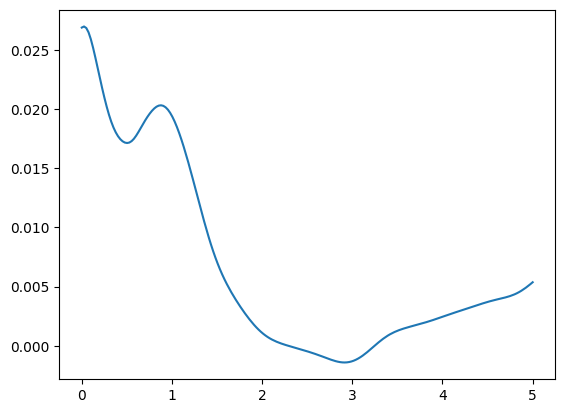

In [23]:
plt.plot(time, portance)

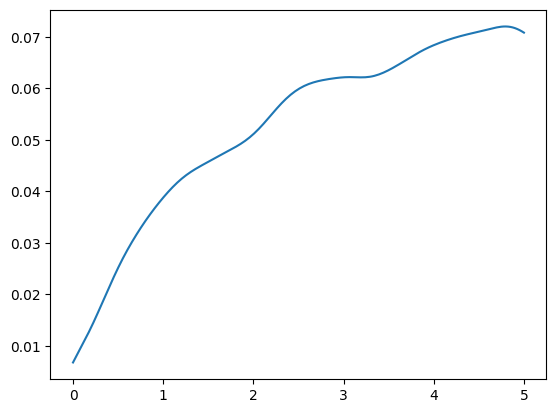

In [24]:
plt.plot(time, traine)